In [1]:
%%capture
%cd ..

In [77]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from celluloid import Camera
from modules.derivatives import second_4
import matplotlib.gridspec as gridspec
cpu_count()

36

In [4]:
from dataclasses import dataclass
from collections.abc import Callable

@dataclass
class HProblem1D:
    dt: float
    dx: float
    L:  float
    f:  Callable[[float], float]
    g:  Callable[[float], float]
    x0: float=0
    u:  float=1
    left_free:  bool=False
    right_free: bool=False
    h:  Callable[[float, float, float], float] = None

    def __post_init__(self):
        self.N = int((self.L - self.x0)/self.dx)
        self.x = np.linspace(self.x0, self.L, self.N)
        self._t = [0]
        self._Y = [self.f(self.x)[1:-1]]
        self._f0 = self.f(self.x0)
        self._fL = self.f(self.L)

    def _get_alpha(self, i: int=-1):
        return self._f0 if not self.left_free else self._Y[i][0]
    
    def _get_beta(self, i: int=-1):
        return self._fL if not self.right_free else self._Y[i][-1]
    
    @property
    def y(self):
        return np.r_[self._get_alpha(-1), self._Y[-1], self._get_beta(-1)]
    
    @property
    def t(self):
        return np.stack(self._t)
    
    @property
    def Y(self):
        return np.stack([
            np.r_[
                self._get_alpha(i), 
                self._Y[i], 
                self._get_beta(i),
            ] 
            for i in range(len(self._Y))
        ])
    
    @property
    def b(self):
        return np.r_[self._get_alpha(-1), np.zeros(self.N-4), self._get_beta(-1)]
    
    def get_h(self, i: int):
        if self.h == None:
            return 0
        else:
            return self.h(self._t[i], self.x[1:-1], self._Y[i])
    
    def get_grid_extents(self):
        return self.x.min(), self.x.max(), self.t.min(), self.t.max()
    
    def run(self, steps: int):
        for _ in range(steps):
            self.step()

class Wave1D(HProblem1D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._Y.append(
            self.f(self.x[1:-1]) + self.dt*self.g(self.x[1:-1]) + (self.dt**2/2)*(self.get_h(0) + self.u**2*second_4(f, self.dx))
        )
        self._t.append(self.dt)

        self.lamb = (self.u*self.dt/self.dx)**2
        self.LAMB = 2*(1 - self.lamb)*np.identity(self.N-2) + self.lamb*(np.diagflat(np.ones(self.N-3), 1) + np.diagflat(np.ones(self.N-3), -1))
    
    def step(self):
        self._Y.append(self.LAMB.dot(self._Y[-1]) - self._Y[-2] + self.lamb*self.b + self.dt**2*self.get_h(-1))
        self._t.append(self._t[-1] + self.dt)

In [168]:
a = np.arange(4)
b = np.arange(3, 7)
a.dot(b), np.sum(a*b)

(32, 32)

In [271]:
def coefficients(M, N, alpha, sym: bool=True):
    assert len(alpha) == N + 1
    delta = np.full((M + 1, N + 1, N + 1), sp.Rational(0) if sym else 0)
    one = sp.Rational(1) if sym else 1
    delta[0, 0, 0] = one
    c1 = one
    for n in range(1, N+1):
        c2 = one
        for nu in range(n):
            c3 = alpha[n] - alpha[nu]
            c2 *= c3
            for m in range(min(n, M) + 1):
                delta[m, n, nu] = (alpha[n]*delta[m, n-1, nu] - m*delta[m-1, n-1, nu])/c3
        for m in range(min(n, M) + 1):
            delta[m, n, n] = (c1/c2)*(m*delta[m-1, n-1, n-1] - alpha[n-1]*delta[m, n-1, n-1])
        c1 = c2
    return delta[M, N]

class WaveRK(HProblem1D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        forward = (
            coefficients(2, 4, (-1, 0, 1, 2, 3)).astype(float)[np.newaxis],
            coefficients(2, 4, (0, 1, 2, 3, 4)).astype(float)[np.newaxis]
        )
        central = coefficients(2, 4, (-2, -1, 0, 1, 2)).astype(float)

        M = np.zeros((self.N-4, self.N))
        for loc, value in enumerate(central):
            M += np.diagflat(np.full(self.N-loc, value), loc)[:-4]
        for i in range(2):
            k, l = 0, self.N-5
            M = np.r_[np.pad(forward[i], [(0, 0), (k, l)]), M, np.pad(forward[i][:, ::-1], [(0, 0), (l, k)])]
        self.M = M

        self._Y = [self.f(self.x)]
        self._dY = [self.g(self.x)]
    
    def _ddY(self, t, y):
        return self.u**2*self.M.dot(y)/self.dx**2 + self.h(t, self.x, y)
    
    def F(self, t, Y):
        y, dy = Y
        return np.stack((dy, self._ddY(t, y)))
        
    @property
    def dY(self):
        return np.stack(self._dY)
    
    @property
    def Y(self):
        return np.stack(self._Y)
    
    @property
    def y(self):
        return np.r_[self._Y[-1]]

    def step(self):
        t = self._t[-1]
        dt = self.dt
        Y = np.stack((self._Y[-1], self._dY[-1]))

        k1 = dt*self.F(t, Y)
        k2 = dt*self.F(t + dt/2, Y + k1/2)
        k3 = dt*self.F(t + dt/2, Y + k2/2)
        k4 = dt*self.F(t + dt, Y + k3)

        y, dy = Y + (k1 + 2*k2 + 2*k3 + k4)/6
        self._dY.append(dy)
        self._Y.append(y)
        self._t.append(t + dt)

In [272]:
@dataclass
class Kink:
    v: float
    c: float
    lamb: float

    def __post_init__(self):
        beta = self.v/self.c
        self.gamma = 1/(1 - beta**2)**0.5
        self.delta = (2/self.lamb)**0.5
    
    def Z(self, x, t):
        return self.gamma*(x - self.v*t)
    
    def __call__(self, x, t, x0=0):
        return np.tanh(self.Z(x=(x - x0), t=t)/self.delta)
    
    def d_dt(self, x, t, x0=0):
        return (-self.gamma*self.v/self.delta)/np.cosh(self.Z(x=(x - x0), t=t)/self.delta)**2
    
    def static(self, x0=0):
        return (
            lambda x: self.__call__(x=x, t=0, x0=x0),
            lambda x: self.d_dt(x=x, t=0, x0=x0)
        )
    
    def h(self, t, x, y):
        return self.lamb*y*(1 - y**2)
    
    @property
    def reflected(self):
        return type(self)(v=-self.v, c=self.c, lamb=self.lamb)
    
    @property
    def antikink(self):
        return AntiKink(v=self.v, c=self.c, lamb=self.lamb)

class AntiKink(Kink):
    def __call__(self, x, t, x0=0):
        return -Kink.__call__(self, x=x, t=t, x0=x0)
    
    def d_dt(self, x, t, x0=0):
        return -Kink.d_dt(self, x=x, t=t, x0=x0)
    
    @property
    def kink(self):
        return Kink(v=self.v, c=self.c, lamb=self.lamb)

In [62]:
def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

In [275]:
c = 1
x0 = 10
v = 0.9
kink = Kink(v=v, c=1, lamb=2)
f1, g1 = kink.static(x0=-x0)
f2, g2 = kink.antikink.reflected.static(x0=x0)

def f(x):
    return f1(x) + f2(x) - 1

def g(x):
    return g1(x) + g2(x)

wave = WaveRK(
    dt= 0.01,
    dx= 0.05,
    x0= -20,
    L= 20,
    f= f,
    g= g,
    u= c,
    h= kink.h
)

T = (wave.L + x0)/v
M = int(T/wave.dt)
fig = plt.figure(figsize=(10, 3))
camera = Camera(fig)
for _ in range(M):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

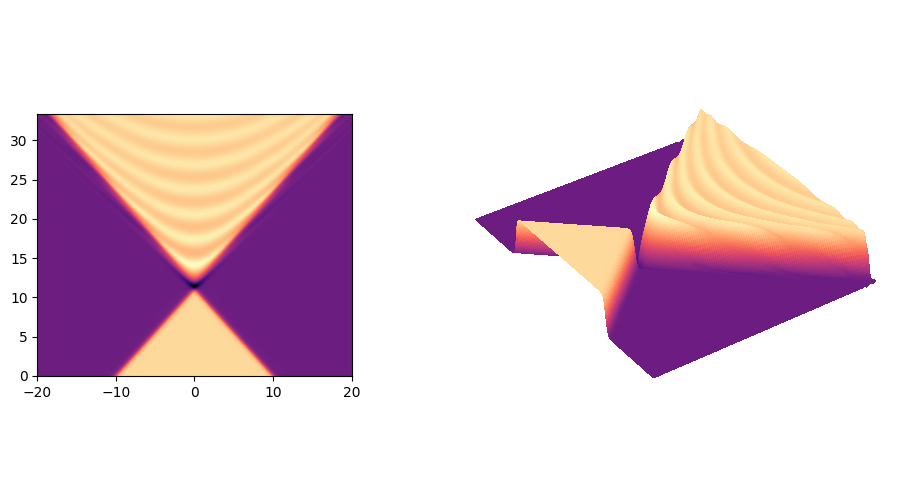

In [276]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 3, wspace=0.0)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=wave.get_grid_extents(), cmap='magma')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(gs[1:], projection='3d')
(X, Y), Z = np.meshgrid(wave.x, wave.t), wave.Y*3
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=False, cmap='magma')
ax2.view_init(azim=-35, elev=35)
ax2.set_aspect('equal')
ax2.grid(False)
ax2.axis('off')

plt.show()

In [278]:
c = 1
v = 0.9

x1 = -10
x2 = 10
d = 1

kink = Kink(v=v, c=c, lamb=2)
f1, g1 = kink.static(x0=x1 - d)
f2, g2 = kink.antikink.static(x0=x1 + d)
f3, g3 = kink.reflected.static(x0=x2 - d)
f4, g4 = kink.antikink.reflected.static(x0=x2 + d)

def f(x):
    return f1(x) + f2(x) + f3(x) + f4(x) - 1

def g(x):
    return g1(x) + g2(x) + g3(x) + g4(x)

wave = WaveRK(
    dt= 0.01,
    dx= 0.05,
    x0= -20,
    L= 20,
    f= f,
    g= g,
    u= c,
    h= kink.h
)

T = (wave.L + x0)/v
M = int(T/wave.dt)

fig = plt.figure(figsize=(10, 3))
plt.gca().set_aspect(3)
camera = Camera(fig)
for _ in range(M):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

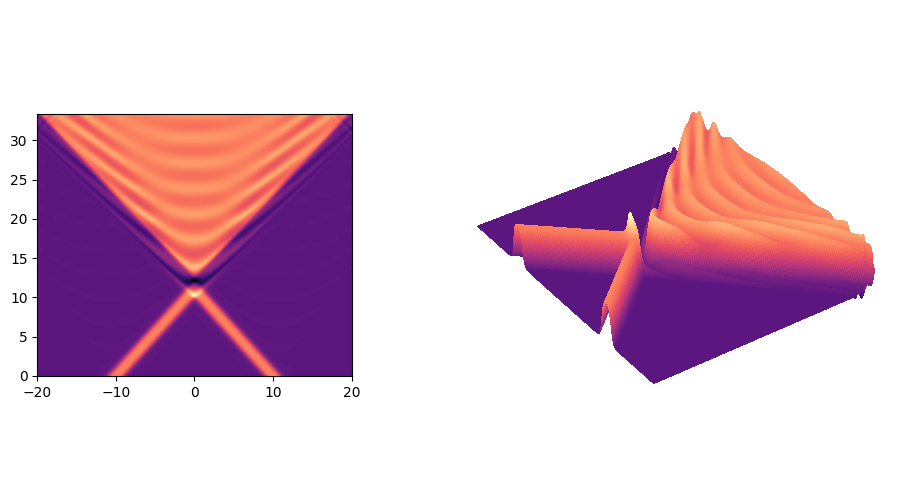

In [279]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 3, wspace=0.0)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=wave.get_grid_extents(), cmap='magma')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(gs[1:], projection='3d')
(X, Y), Z = np.meshgrid(wave.x, wave.t), wave.Y*3
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=False, cmap='magma')
ax2.view_init(azim=-35, elev=35)
ax2.set_aspect('equal')
ax2.grid(False)
ax2.axis('off')

plt.show()

In [281]:
c = 1
v = 0.9

x1 = -10
x2 = 10
d = 3

kink = Kink(v=v, c=c, lamb=2)
f1, g1 = kink.static(x0=x1 - d)
f2, g2 = kink.antikink.static(x0=x1 + d)
f3, g3 = kink.reflected.static(x0=x2 - d)
f4, g4 = kink.antikink.reflected.static(x0=x2 + d)

def f(x):
    return f1(x) + f2(x) + f3(x) + f4(x) - 1

def g(x):
    return g1(x) + g2(x) + g3(x) + g4(x)

wave = WaveRK(
    dt= 0.01,
    dx= 0.05,
    x0= -20,
    L= 20,
    f= f,
    g= g,
    u= c,
    h= kink.h
)

T = (wave.L + x0)/v
M = int(T/wave.dt)

fig = plt.figure(figsize=(10, 3))
plt.gca().set_aspect(3)
camera = Camera(fig)
for _ in range(M):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

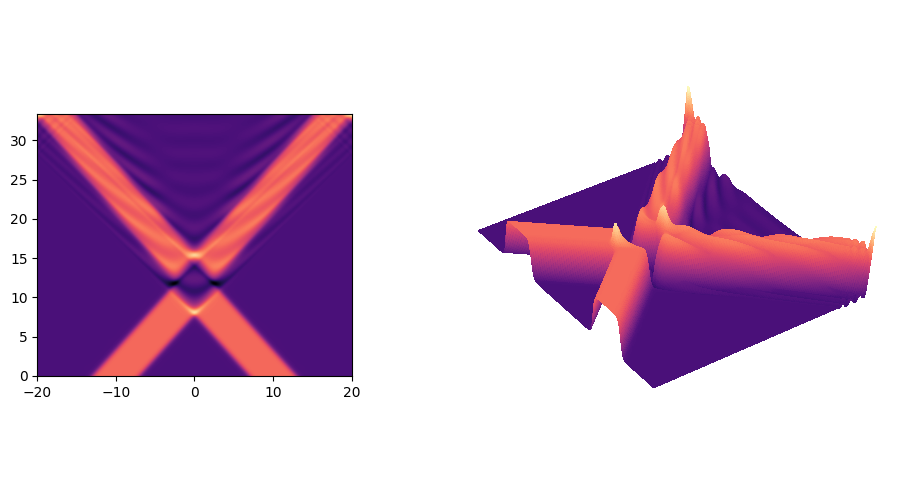

In [282]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 3, wspace=0.0)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=wave.get_grid_extents(), cmap='magma')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(gs[1:], projection='3d')
(X, Y), Z = np.meshgrid(wave.x, wave.t), wave.Y*3
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=False, cmap='magma')
ax2.view_init(azim=-35, elev=35)
ax2.set_aspect('equal')
ax2.grid(False)
ax2.axis('off')

plt.show()